# Nodding Data Reduction

This tutorial shows the reduction path of a nodding observation with a multi-beam receiver, the K-band Focal Plane Array (KFPA).

Similar to a position-switched observation, two beams are selected for simultaneous observing (though the receiver can have more than two beams). In the first scan BEAM1 is looking at the source, while BEAM2 is looking at an assumed OFF position. In the next scan, BEAM2 will be looking at the source, while BEAM1 is looking at (another) OFF position. This will result in two position-switched solutions, which are then averaged for the final spectrum. 

One advantage of this observing mode is that the telescope is always ON source, bringing the noise down by $\sqrt{2}$ compared to a classic position switched observation. Minus a small amount of slewing time of course. However, the beam separation in the receiver should be large enough to ensure that the off position is not on the source. Otherwise, a proper Position Switching observation is needed with a large enough offset.

In the observations used in this tutorial there are also position switched observations of the same source, so we can compare the results of using beam nodding versus position switching.

The data in this tutorial were also presented in https://gbtdocs.readthedocs.io/en/latest/how-tos/data_reduction/gbtidl.html#basic-nodding in a similar GBTIDL data reduction.

## Background

The spectral line observed here is the NH$_3$ (1,1) line at 23.69 GHz with the KFPA receiver. This receiver has 7 beams: one central beam and six beams in a roughly hexagonal pattern around the central beam. The source is a position in the W3 cloud, a roughly two degree sized Giant Molecular Cloud (GMC) with active star formation. See also https://herscheltelescope.org.uk/results/w3-star-forming-region/

## Dysh commands

The following dysh commands are introduced (leaving out all the function arguments):

      filename = dysh_data()
      sdf = GBTFITSLoad()
      sb = sdf.getnod()
      ta = sb.timeaverage()
      ta.baseline()
      ta.smooth()
      ta.average()
      ta.plot()
      ta.plot().spectrum


## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.log import init_logging
from dysh.fits.gbtfitsload import GBTFITSLoad
from astropy import units as u

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path

## Setup Logging

`dysh` uses a logger to communicate. If you are working in the command line, then the logging is setup for you. If you are working in a jupyter lab instance, then you need to set it up. You can do so using the `init_logging` function imported above. As an argument, `init_logging` takes a number, the verbosity `level`. `level` 0 is for error messages only, 1 for warning, 2 for info and 3 for debug. Here we set it to `level` 2. 

In [2]:
init_logging(2)

# also create a local "output" directory where temporary notebook files can be stored.
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

## Data Retrieval

Download the example SDFITS data, if necessary.

In [3]:
filename = dysh_data(example="nod2")

12:31:46.993 I Resolving example=nod2 -> nod-KFPA/data/TGBT22A_503_02.raw.vegas.trim.fits


## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

This trimmed dataset is an extraction from a much larger dataset (19GB) and can take some time to load if it's the first time. This would be `example="nod"`


In [4]:
sdfits = GBTFITSLoad(filename)

In [5]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
60,W3_1,-40.0,OnOff,1,23.694496,23.694496,1,1,31,1,324.2279,38.7060
61,W3_1,-40.0,OnOff,2,23.694496,23.694496,1,1,31,1,324.1526,39.0121
62,W3_1,-40.0,Nod,1,23.694496,23.694496,1,1,31,7,324.2743,38.4194
63,W3_1,-40.0,Nod,2,23.694496,23.694496,1,1,31,7,324.3672,38.2858


## Data Reduction

### Nodding Data Reduction

We start calibrating the Nod observations in scans 62 and 63. We use the `GBTFITSLoad.getnod` method to calibrate the data. This method will automatically find a pair of Nod scans given one scan number. It will also automatically figure out which feeds where used during the nodding observations. The return of `getnod` is a `ScanBlock` with at least two `NodScan` in it.

In [6]:
nodsb = sdfits.getnod(scan=62, ifnum=0, plnum=0)
nodsb

12:31:47.690 I Ignoring 1 blanked integration(s).
12:31:47.855 I Ignoring 1 blanked integration(s).


ScanBlock([<dysh.spectra.scan.NodScan at 0x7f9a94fac310>,
           <dysh.spectra.scan.NodScan at 0x7f9a951c3050>])

Each `NodScan` holds all of the calibrated integrations for each feed used during the Nod observations.
We can query the `NodScan` objects for information about the data, such as what is the system temperature, in K, or the exposure time, in seconds. `NodScan` is a sub class of a `Scan` object.

In [7]:
nodsb[0].tsys, nodsb[1].tsys

(array([64.0651583 , 65.84723928, 63.32246857, 64.9772735 , 63.77161495,
        62.82267302, 66.41525105, 62.88090753, 60.91140946, 62.18854417,
        60.81960096, 61.42624138, 59.32883166, 60.16711155, 61.45232073,
        60.71780304, 59.21079399, 62.45297224, 62.54435652, 64.53549963,
        65.65949202, 64.34252275, 64.24356553, 65.4308054 , 65.54581989,
        64.64741319, 62.45646939, 62.62895287, 61.91170188, 63.05362163]),
 array([73.42457338, 73.89318167, 77.95484204, 77.06676577, 79.64183646,
        80.67187842, 75.41180075, 74.18340271, 79.06335209, 82.58279698,
        78.22566126, 70.88384081, 68.7912057 , 69.28174137, 72.48114802,
        72.24762512, 74.46373175, 73.26477026, 73.02711593, 70.51565007,
        72.7222005 , 71.37948284, 71.11466717, 70.09686344, 70.74295942,
        69.47116087, 70.22771754, 67.13519555, 70.62961633, 69.03334933]))

In [8]:
nodsb[0].exposure, nodsb[1].exposure

(array([0.97587454, 0.97236673, 0.97587454, 0.97095654, 0.97587454,
        0.97587454, 0.97060335, 0.97587454, 0.97060334, 0.97587454,
        0.97587454, 0.97587454, 0.97060334, 0.97587454, 0.97060334,
        0.97587454, 0.97587454, 0.97095652, 0.97587454, 0.97095652,
        0.97587454, 0.97587454, 0.97060334, 0.97587454, 0.97060335,
        0.97587454, 0.97587454, 0.97060335, 0.97587454, 0.97587454]),
 array([0.97587454, 0.97201457, 0.97587454, 0.97095654, 0.97587454,
        0.97587454, 0.97095654, 0.97587454, 0.97060334, 0.97587454,
        0.97587454, 0.97587454, 0.97095654, 0.97587454, 0.97060334,
        0.97587454, 0.97587454, 0.97060334, 0.97587454, 0.97095652,
        0.97587454, 0.97587454, 0.97095654, 0.97587454, 0.97095654,
        0.97587454, 0.97587454, 0.97095654, 0.97587454, 0.97587454]))

In [9]:
nodsb[0].fdnum, nodsb[1].fdnum

(2, 6)

From the above we see that the beams used for nodding had fdnum of 2 and 6.

#### Inspecting Integrations

To access the calibrated integrations we use the `calibrated` method of a `Scan` object. The return is a `Spectrum` object with the calibrated data. The argument to `calibrated` is the integration number.

In [10]:
nod_int = nodsb[0].getspec(0)
nod_int

<Spectrum(flux=[nan ... 1.7525684833526611] K (shape=(32768,), mean=3.35429 K); spectral_axis=<SpectralAxis 
   (observer: <ITRS Coordinate (obstime=2022-02-17T03:12:46.500, location=(0., 0., 0.) km): (x, y, z) in m
                  (882593.9465029, -4924896.36541728, 3943748.74743984)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <SkyCoord (FK5: equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
                (36.37731467, 62.10479638, 1000000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (-3.65939096e-22, 0., -40.)>
    observer to target (computed from above):
      radial_velocity=-18.32211713933814 km / s
      redshift=-6.111413678810962e-05
    doppler_rest=23694495500.0 Hz
    doppler_convention=radio)
  [2.36845708e+10 2.36845715e+10 2.36845722e+10 ... 2.37080061e+10
 2.37080069e+10 2.37080076e+10] Hz> (length=32768))>

`Spectrum` objects have convenience functions to plot, smooth, and remove baselines, among others. Here we use the `plot` function to display the calibrated data for the first integration.

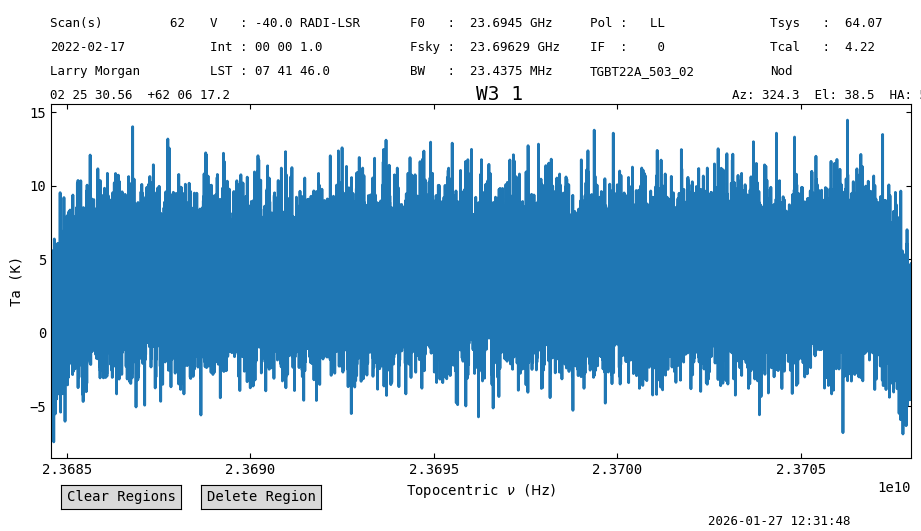

In [11]:
nod_int.plot()

The plot shows a noise-like signal since it is only one 1 s integration. To see more details, and potentially a signal, we must time average the data.

#### Time Averaging

To time average we can use the `timeaverage` function. We can use this function directly from a `ScanBlock`, in which case all of the data in the `ScanBlock` will be time averaged, or from a `Scan`, and only average the data inside the `Scan`. Here we will average all the data in the `ScanBlock`.

By default time averaging uses the following weights: 
$$
\frac{T^{2}_{sys}}{\Delta\nu\Delta t}
$$
with $T_{sys}$ the system temperature, $\Delta\nu$ the channel width and $\Delta t$ the integration time. In `dysh` these are set using `weights='tsys'` (the default).

The return of `timeaverage` is a `Spectrum` object.

In [12]:
nod_ta = nodsb.timeaverage()
nod_ta

<Spectrum(flux=[-0.1644217560943768 ... -0.1069810589978196] K (shape=(32768,), mean=0.37476 K); spectral_axis=<SpectralAxis 
   (observer: <ITRS Coordinate (obstime=2022-02-17T03:12:46.500, location=(0., 0., 0.) km): (x, y, z) in m
                  (882593.9465029, -4924896.36541728, 3943748.74743984)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <SkyCoord (FK5: equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
                (36.38569729, 62.08575673, 1000000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (-7.31878192e-22, 7.31878192e-22, -40.)>
    observer to target (computed from above):
      radial_velocity=-18.31506656158766 km / s
      redshift=-6.109062002923604e-05
    doppler_rest=23694495500.0 Hz
    doppler_convention=radio)
  [2.36845708e+10 2.36845715e+10 2.36845722e+10 ... 2.37080061e+10
 2.37080069e+10 2.37080076e+10] Hz> (length=32768))>

Now we plot the time average.

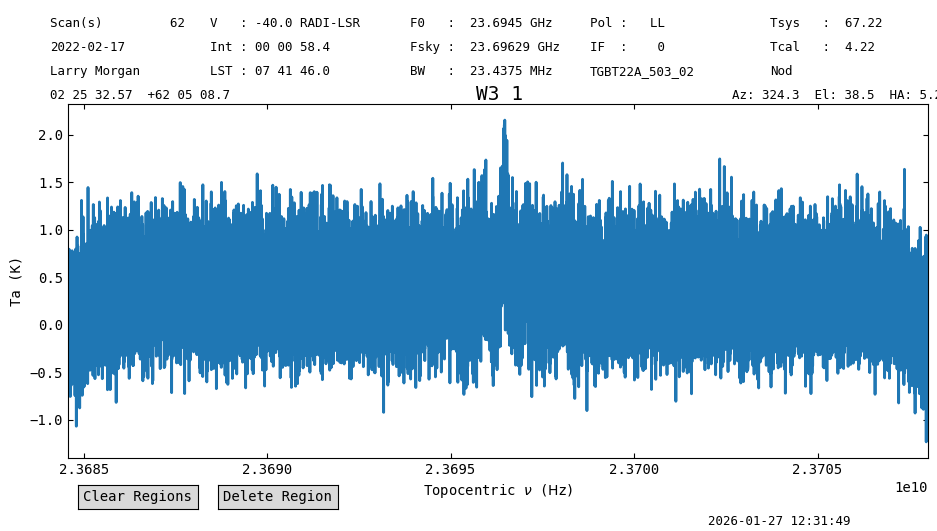

In [13]:
nod_ta.plot()

We see hints of a line. We can further reduce our data to bring out the signal from the noise.

#### Smoothing

One way of reducing the noise in the time average is by smoothing the data along the spectral axis. This is done using the `Spectrum.smooth` function. The first argument is the kernel, and the second the width of the kernel in channels. The available kernels are a boxcar, Gaussian and a Hanning window. We use a boxcar with a width of 51 channels.

In [14]:
nod_ta_smooth = nod_ta.smooth('box', 51)

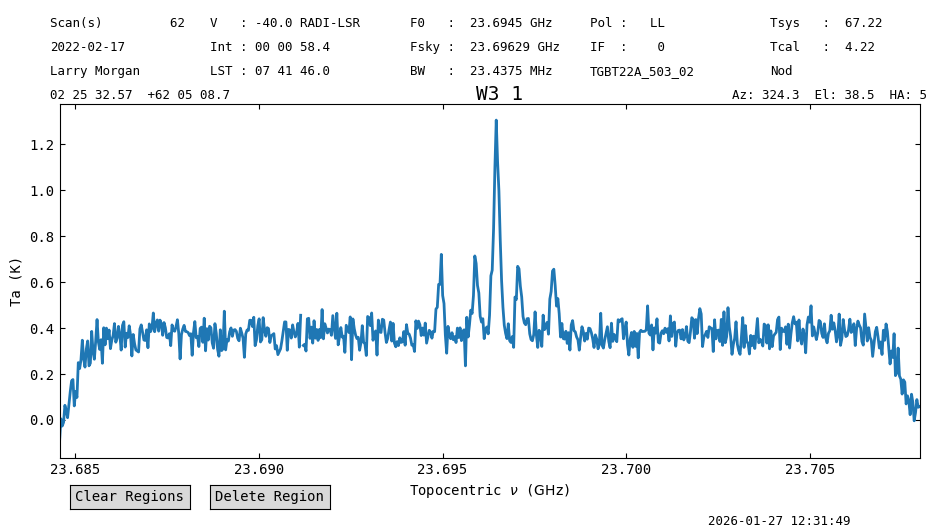

In [15]:
nod_ta_smooth.plot(xaxis_unit="GHz")

The signal is clear now. 

#### Statistics

We can quantify the reduction in the noise using the `Spectrum.stats` function. To reduce the bias in the statistics, we will slice the spectrum to avoid the bandpass roll off channels. We use a channel range between 23.687 and 23.694 GHz.

In [16]:
s = slice(23.687*u.GHz, 23.694*u.GHz)

In [17]:
nod_ta_smooth[s].stats()  # rms 0.04587208 K

12:31:50.630 I Note: found 1 NaN (masked) values


{'mean': <Quantity 0.37603134 K>,
 'median': <Quantity 0.38060803 K>,
 'rms': <Quantity 0.04587208 K>,
 'min': <Quantity 0.2620557 K>,
 'max': <Quantity 0.48034966 K>,
 'npt': 191,
 'nan': 1}

In [18]:
nod_ta[s].stats() # rms 0.33878936 K

12:31:51.030 I Note: found 52 NaN (masked) values


{'mean': <Quantity 0.37586728 K>,
 'median': <Quantity 0.36945948 K>,
 'rms': <Quantity 0.33836405 K>,
 'min': <Quantity -0.92130555 K>,
 'max': <Quantity 1.58757768 K>,
 'npt': 9787,
 'nan': 52}

Before smoothing the rms was 339 mK, after smoothing it went down to 46 mK, so the reduction in the noise is 6% higher than $\sqrt{51}$.

#### Baseline Subtraction

Now we will subtract a baseline from the data. We use the `Spectrum.baseline` function to do it. We will ignore the edge channels and the region with line emission during the baseline fitting. This is specified with the `exclude` or `include` argument of `baseline`. Here we use `include`. Since the line free channels seem to have a flat frequency response, away from the window edges, we use an order 1 polynomial as our baseline model.

In [19]:
include = [(23.687*u.GHz, 23.694*u.GHz),
           (23.700*u.GHz, 23.705*u.GHz)
          ]
model = "poly"
order = 1

nod_ta_smooth.baseline(order, model=model, include=include, remove=True)

12:31:51.038 I EXCLUDING [Spectral Region, 1 sub-regions:
  (23684570787.125 Hz, 23687000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (23694000000.0 Hz, 23700000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (23705000000.0 Hz, 23707989690.47583 Hz) 
]


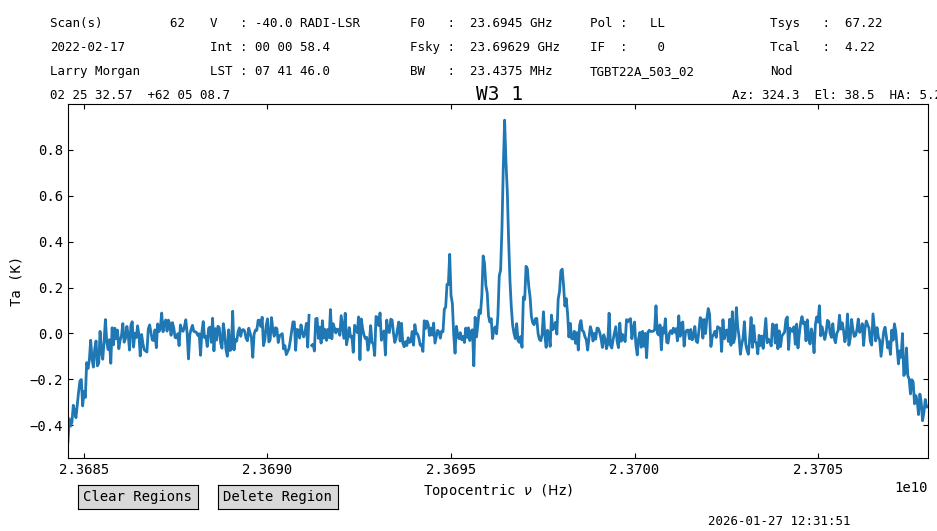

In [20]:
nod_ta_smooth.plot()

Now we will proceed with the calibration of the OnOff observations for comparison.

### OnOff Data Reduction

Scans 60 and 61 contain OnOff observations (position switched). For the 7-beam KFPA receiver, the central beam (`fdnum=0`) will be the source tracking beam for the OnOff observations. As with the Nod calibration, dysh knows how to pair OnOff observations given a scan number. We use the `GBTFITSLoad.getps` function to calibrate position switched observations. As with `getnod`, the return of `getps` is a `ScanBlock`, but this time containing `PSScan` objects, which are also sub classes of the `Scan` class, so they share many of their functions and properties.

In [21]:
pssb = sdfits.getps(scan=60, plnum=0, ifnum=0, fdnum=0)
pssb

12:31:51.405 I Ignoring 1 blanked integration(s).


ScanBlock([<dysh.spectra.scan.PSScan at 0x7f9a92fa9590>])

We time average, smooth and baseline subtract the calibrated data. We use a chain of functions for the time averaging and smoothing.

In [22]:
ps_ta_smooth = pssb.timeaverage().smooth("box", 51)
ps_ta_smooth.baseline(order, model=model, include=include, remove=True)

12:31:51.690 I 23707989720.475834 Hz is above the maximum spectral axis 23707989720.47583 Hz. Replacing.
12:31:51.691 I EXCLUDING [Spectral Region, 1 sub-regions:
  (23684570817.125004 Hz, 23687000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (23694000000.0 Hz, 23700000000.0 Hz) 
, Spectral Region, 1 sub-regions:
  (23705000000.0 Hz, 23707989720.47583 Hz) 
]


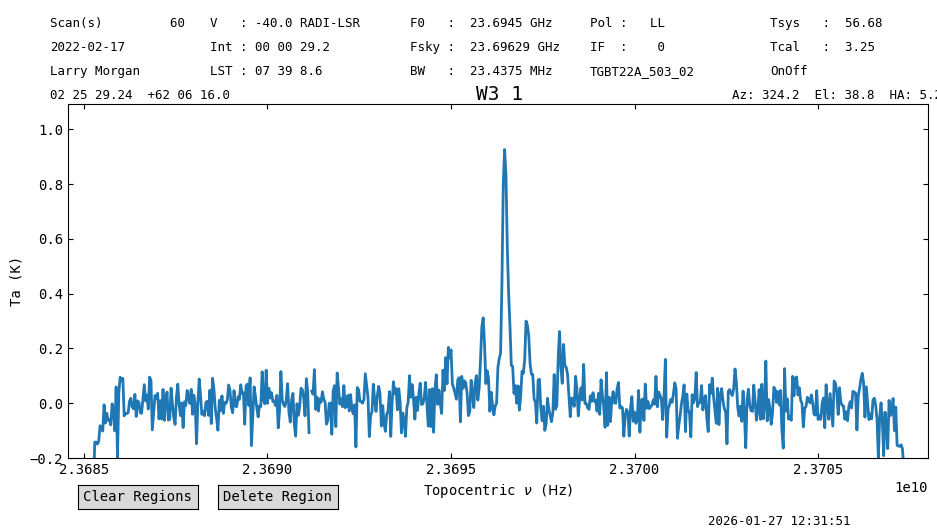

In [23]:
ps_ta_smooth.plot(ymin=-0.2)

## Comparing the Methods

Both the Nod and OnOff scans shows a signal, How do the properties of the spectra compare?

In [24]:
# Line free rms
nod_ta_smooth[s].stats()["rms"], ps_ta_smooth[s].stats()["rms"]

12:31:52.330 I Note: found 1 NaN (masked) values
12:31:52.706 I Note: found 1 NaN (masked) values


(<Quantity 0.04586959 K>, <Quantity 0.0557227 K>)

The noise in the Nod spectrum is lower than that in the OnOff one. This makes sense since the exposure time in the Nod observations is almost twice as long as in the OnOff ones, for the same observing time. If that is the only factor, we would expect the noise in the Nod spectrum to be a factor $\sqrt{2}$ lower than the OnOff one. Let's check.

In [25]:
ps_ta_smooth[s].stats()["rms"]/nod_ta_smooth[s].stats()["rms"]/2**0.5

12:31:53.122 I Note: found 1 NaN (masked) values
12:31:53.533 I Note: found 1 NaN (masked) values


<Quantity 0.85899819>

The ratio is 0.85, meaning that the noise reduction was 15% less than expected. This is likely because the system temperature of the feeds is different. Let's check.

In [26]:
ps_ta_smooth.meta["TSYS"]/nod_ta_smooth.meta["TSYS"]

0.8432606926356401

The system temperature of the feed used for the OnOff observations is 15% lower than that of the feeds used for the Nod. This explains the observed difference in the noise.

The line peak is consistent between the Nod and OnOff spectra.

In [27]:
# Line peak
nod_ta_smooth.stats()["max"], ps_ta_smooth.stats()["max"]

12:31:53.565 I Note: found 1 NaN (masked) values
12:31:53.568 I Note: found 2 NaN (masked) values


(<Quantity 0.92860103 K>, <Quantity 0.9264315 K>)

12:31:53.678 I Note: found 1 NaN (masked) values
12:31:53.772 I Note: found 1 NaN (masked) values


(1.0043275608304512, 0.994918029194119)

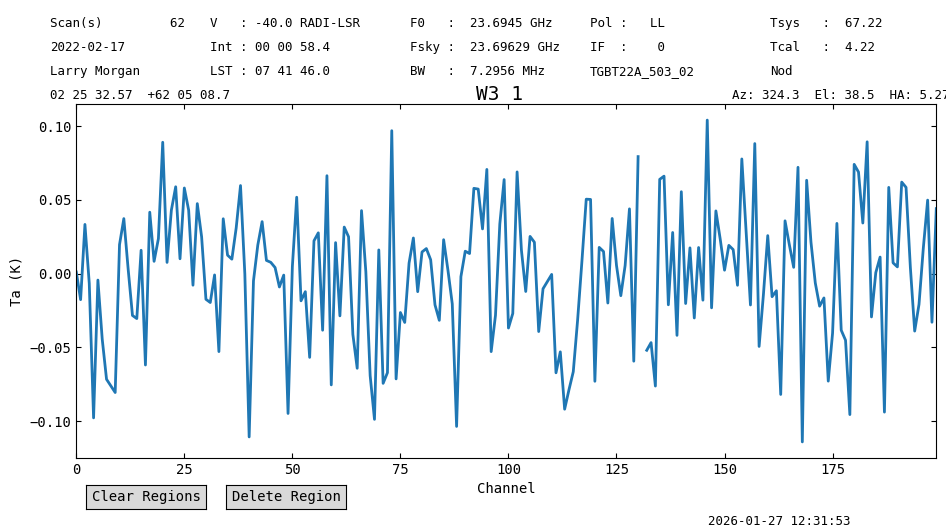

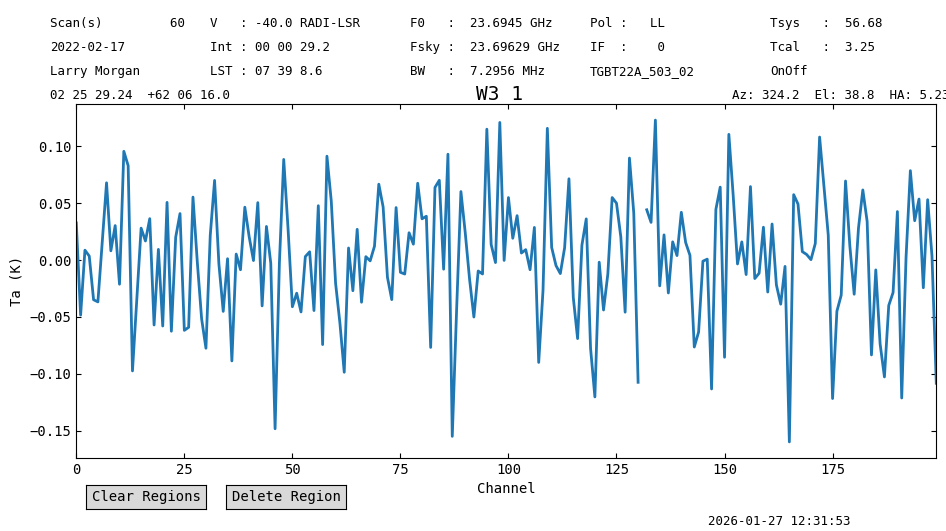

In [28]:
# radiometer in a non-signal part of the spectrum:    (1.0043275608304512, 0.994918029194119) 
nod_ta_smooth[50:250].plot(xaxis_unit="chan").spectrum.radiometer(), ps_ta_smooth[50:250].plot(xaxis_unit="chan").spectrum.radiometer(),

## Final Stats
Finally, at the end we compute some statistics over a spectrum, merely as a checksum if the notebook is reproducable.



In [29]:
nod_ta_smooth.stats()  # rms 0.11354235 K

12:31:54.117 I Note: found 1 NaN (masked) values


{'mean': <Quantity -0.00183858 K>,
 'median': <Quantity 0.00044938 K>,
 'rms': <Quantity 0.11354235 K>,
 'min': <Quantity -0.47174312 K>,
 'max': <Quantity 0.92860103 K>,
 'npt': 643,
 'nan': 1}